# CHECK ATTACK (PERTURBED) FILES

In [1]:
import IPython.display as ipd
import logging
import numpy as np
import librosa
from src.audio_utils import read_audio
from src.utils import *
# from sp_utils import spectrogram_inversion, get_spectrogram_from_audio
# from attacks_utils import retrieve_single_cached_spec, load_spec_model, evaluate_spec, get_pred_class
from check_attacks_utils import check_attack

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True


In [2]:
seed_everything(1234)
set_gpu(-1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
plt.style.use('dark_background')
rate = 16000

GPU selected: 0 - NVIDIA GeForce RTX 3060


In [3]:
###############################################################
#######     insert here data     ##############################
###############################################################

eval_model = 'ResNet'
attack_model = 'ResNet'
attack = 'FGSM'
file_number = 1000147
epsilon = 2.0

In [4]:
def compute_snr(file_number, perturbed_audio):
    clean_audio_path = f'FGSM_ResNet/FGSM_ResNet_dataset_0dot0/FGSM_ResNet_LA_E_{file_number}_0dot0.flac' 
    clean_audio, _ = librosa.load(clean_audio_path, sr=16000)
    noise = clean_audio - perturbed_audio
    signal_power = np.mean(clean_audio**2)
    noise_power = np.mean(noise**2) 
    snr = 10 * np.log10(signal_power/noise_power)
    if snr > 1e5:
        snr = 0
    return snr


    

def check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate):
    perturbed_audio, original_audio, perturbed_spec, original_spec = check_attack(eval_model=eval_model, 
                                                                 attack_model=attack_model, 
                                                                 attack=attack, 
                                                                 file_number=file_number, 
                                                                 epsilon=epsilon, 
                                                                 device=device)
    print(f'SNR: {compute_snr(file_number, perturbed_audio):.2f} dB')
    
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    librosa.display.specshow(original_spec, sr=rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Original signal for file {file_number}')
    plt.subplot(2,1,2)
    librosa.display.specshow(perturbed_spec, sr=rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Perturbed signal with {attack} attack on {attack_model} eps={epsilon}')
    plt.tight_layout()
    plt.show()
    
    return perturbed_audio, original_audio
    

--> File name: FGSM_LA_E_1000147_2dot0.flac
--> Model evaluated: ResNet
--> Attack: FGSM on ResNet
--> Epsilon: 2.0
--> GT label: 1
 --> Predicted label: 0, 
tensor([[-9.1475e-04, -6.9973e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
--> Confidence: 99.91 %
SNR: 17.41 dB


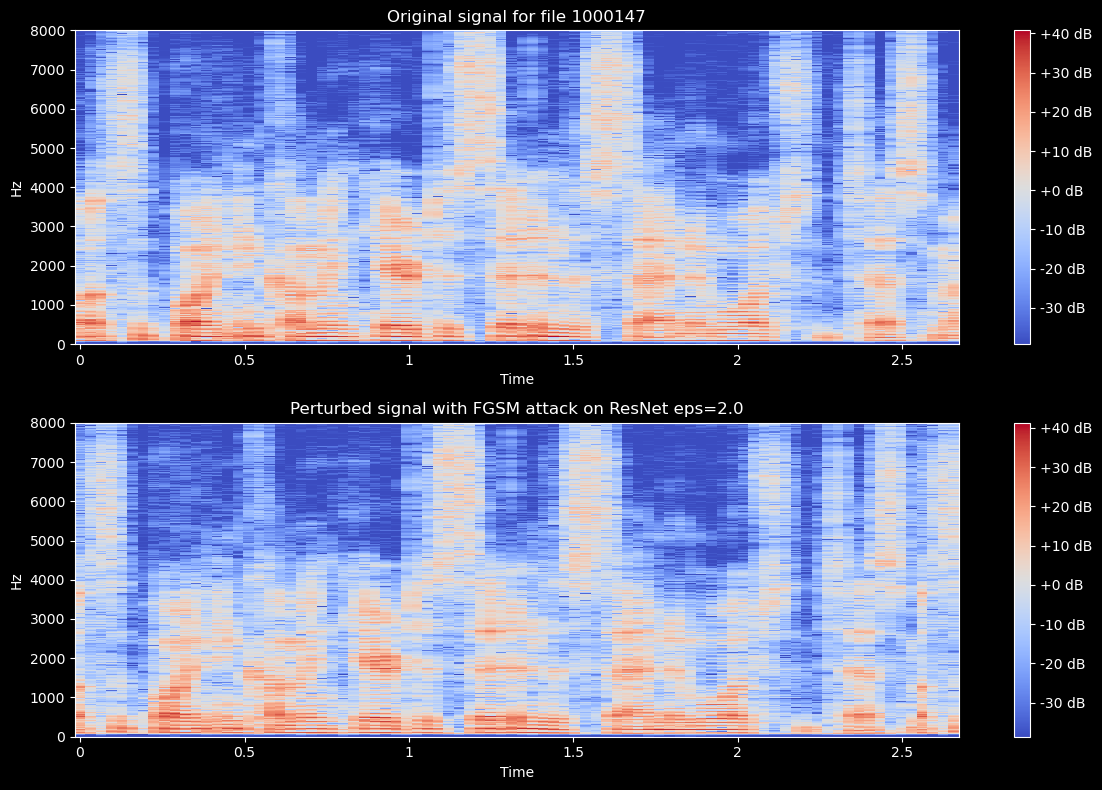

In [5]:
perturbed_audio, original_audio = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate)

In [6]:
ipd.Audio(perturbed_audio, rate=rate)

In [7]:
ipd.Audio(original_audio, rate=rate)

***
## More tests

--> File name: FGSM_LCNN_LA_E_1000147_2dot0.flac
--> Model evaluated: LCNN
--> Attack: FGSM on LCNN
--> Epsilon: 2.0
--> GT label: 1
 --> Predicted label: 0, 
tensor([[-6.7949e-06, -1.1894e+01]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
--> Confidence: 100.00 %
SNR: 17.78 dB


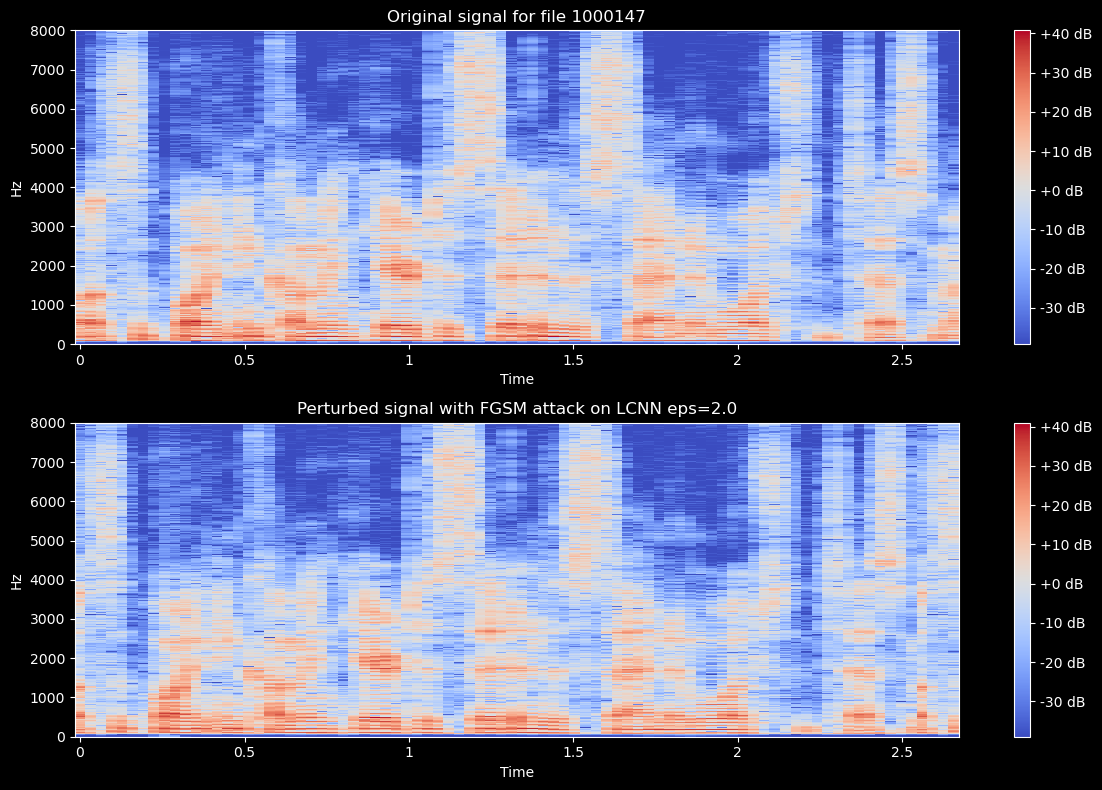

In [11]:
# case A
attack = 'FGSM' 
attack_model = 'LCNN'
eval_model = 'LCNN'
eps = 2.0
file_number = 1000147
perturbed_audio_A, original_audio_A = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate)

--> File name: FGSM_SENet_LA_E_1000147_2dot0.flac
--> Model evaluated: SENet
--> Attack: FGSM on SENet
--> Epsilon: 2.0
--> GT label: 1
 --> Predicted label: 0, 
tensor([[-9.9121e-04, -6.9171e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
--> Confidence: 99.90 %
SNR: 18.20 dB


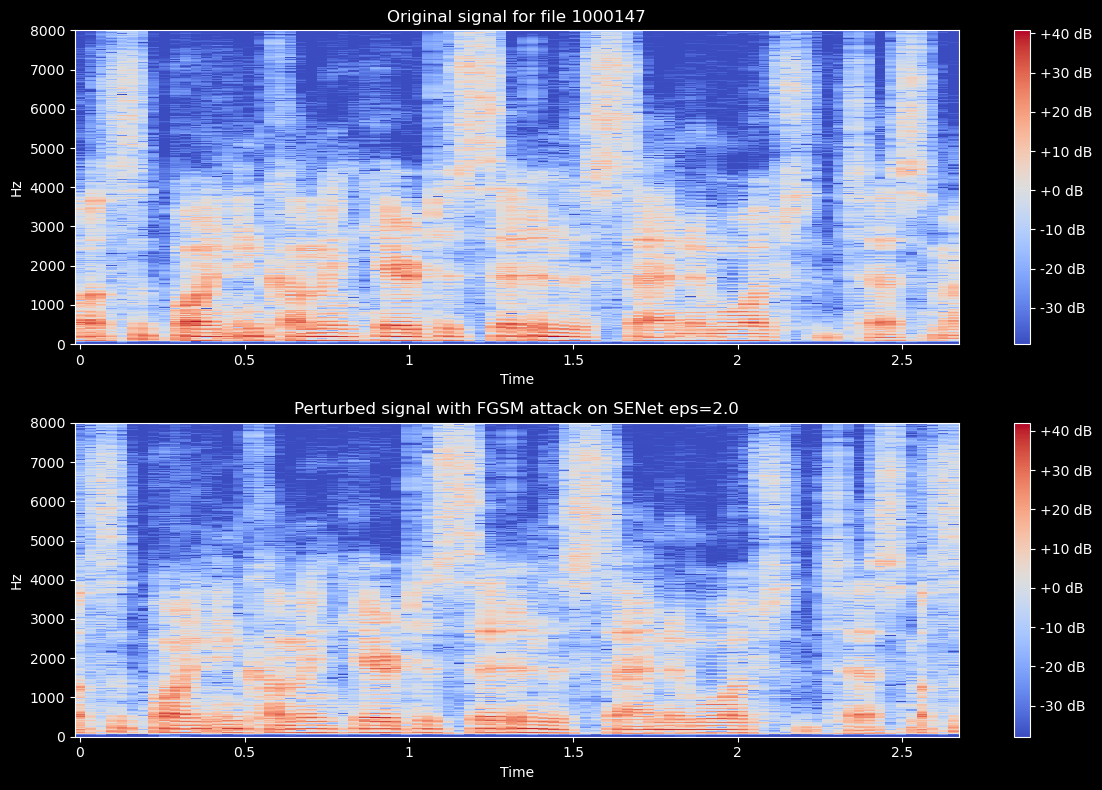

In [12]:
# case B
attack = 'FGSM' 
attack_model = 'SENet'
eval_model = 'SENet'
eps = 2.0
file_number = 1000147
perturbed_audio_B, original_audio_B = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate)

--> File name: BIM_CUT_LCNN_LA_E_2834763_2dot0.flac
--> Model evaluated: LCNN
--> Attack: BIM_CUT on LCNN
--> Epsilon: 2.0
--> GT label: 1
 --> Predicted label: 0, 
tensor([[-7.6887e-05, -9.4736e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
--> Confidence: 99.99 %
SNR: 32.29 dB


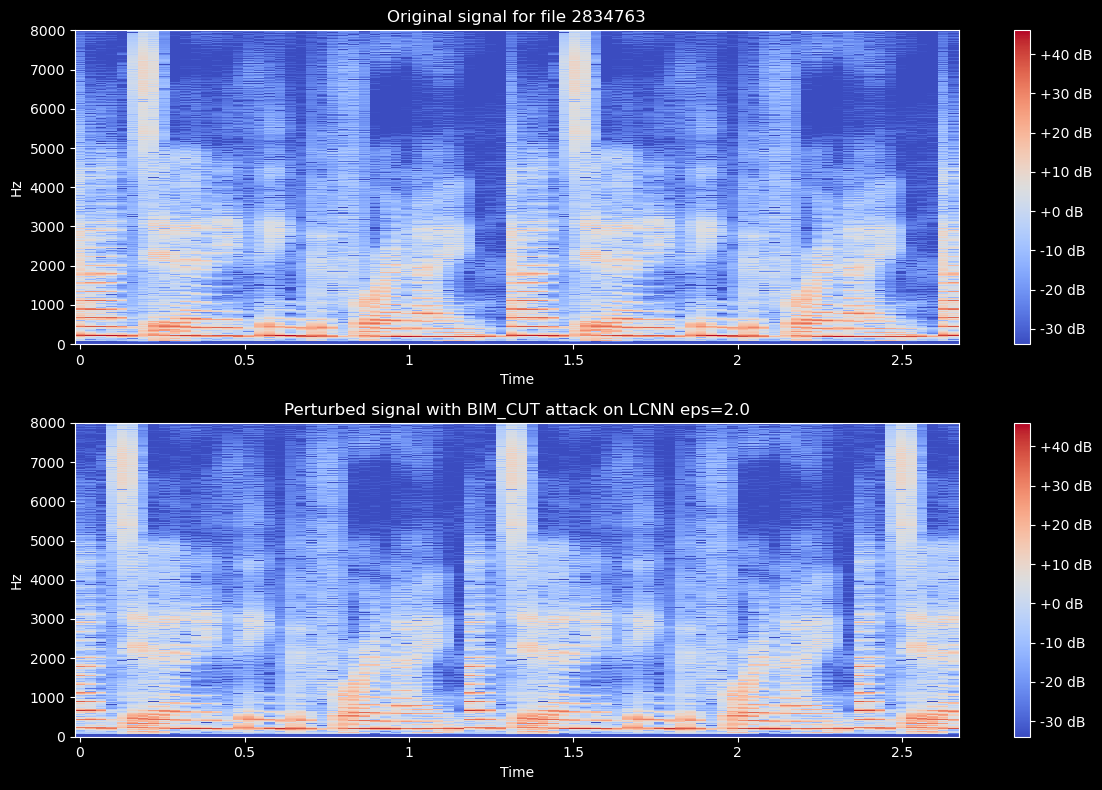

In [15]:
# case C
attack = 'BIM_CUT' 
attack_model = 'LCNN'
eval_model = 'LCNN'
eps = 2.0
file_number = 2834763
perturbed_audio_C, original_audio_C = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, rate)

In [16]:
ipd.Audio(perturbed_audio_C, rate=rate)